### DS-1180 - Introduction to Spetcral Clustering

January 25, 2022

We introduce the Spectral Clustering algorithm and review the component calculations that enter into it. Particularly, we show why the Laplacian is important in defining the connection properties of quantities, how applying PCA ideas to Laplacians leads to a feature representation that emphasizes connections, and finally how Spectral clustering combines the Laplacian, PCA, and K-means clutering to devise an improved algorithm. 

**[I. Motivating Question](#I-Motivating-Question)**

**[II. K-Means Algorithm](#II-K-Means-Algorithm)**  

**[III. Networks and Newton's Law of Cooling](#III-Networks-and-Newton's-Law-of-Cooling)**

**[IV. Definition of the Laplacian](#IV-Definition-of-the-Laplacian)**

**[V. Principal Component Analysis](#V-Principal-Component-Analysis)**

**[VI. Adjacency Matrix From Points](#VI-Adjacency-Matrix-From-Points)**

**[VII. Spectral Clustering Algorithm](#VII-Spectral-Clustering-Algorithm)**

**[VIII. Return to Original Question](#VIII-Return-to-Original-Question)**

**References**
- Ng, Andrew Y., Michael I. Jordan, and Yair Weiss. "On spectral clustering: Analysis and an algorithm." *Advances in neural information processing systems*. 2002. https://ai.stanford.edu/~ang/papers/nips01-spectral.pdf
- Von Luxburg, Ulrike. "A tutorial on spectral clustering." *Statistics and computing* 17.4 (2007): 395-416. https://arxiv.org/abs/0711.0189


In [1]:
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.cluster import SpectralClustering, KMeans
from matplotlib import pyplot as plt
import networkx as nx

## I. Motivating Question
<a id="I-Motivating-Question"></a>

We have a two-dimensional plot of data that looks like

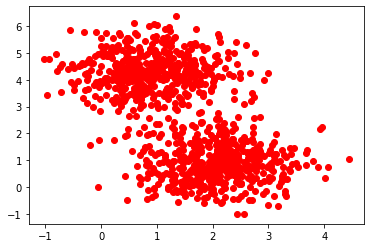

In [2]:
V, clusters = make_blobs(n_samples=1000, centers=2,  cluster_std=.75, random_state=0)
plt.scatter(V[:,0], V[:,1], color= 'r')

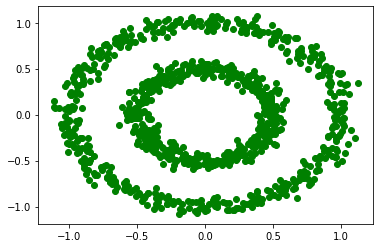

In [3]:
X, clusters = make_circles(n_samples=1000, noise=.05, factor=.5, random_state=0)
plt.scatter(X[:,0], X[:,1], color= 'g')

and another one that looks like

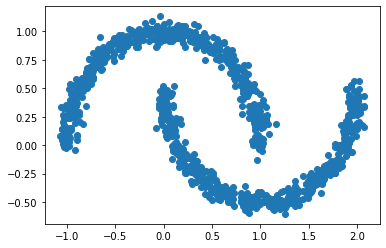

In [4]:
U, clusters = make_moons(n_samples=1000, noise=.05, random_state=0)
plt.scatter(U[:,0], U[:,1])

> How can we find clusters for such plots of points? 

## II K-Means Algorithm
<a id="II-K-Means-Algorithm"></a>

K-means is a standard algorithm for finding clusters of points. It's geometrically intuitive and easy to describe. 

[kmeans_pros_cons.pdf](kmeans_pros_cons.pdf)


**Algorithm**
1. Begin with $N$ points in a $D$ dimensional space
2. Randomly generate $C$ new points as centroids of clusters
3. Label each of the $N$ points as part of the cluster whose centroid is closets to that point
4. Compute the average of all points within a cluster; this is the new centroid. For example the centroid of cluster $k$ is  $$\boldsymbol{\mu}_k = \frac{1}{N_k} \sum_{j: z_j=k} \textbf{x}_j$$ where $N_k$ is number of points in cluster $k$, $z_j$ is the cluster label of point $j$
5. Repeat steps 3 and 4 until the sum over the within cluster sum of squares 
$$\sum_{k=1}^{C}\sum_{j: z_j = k}^{N}||\textbf{x}_j - \boldsymbol{\mu}_k||^2)$$
is minimized

Applying the algorithm to our three data sets

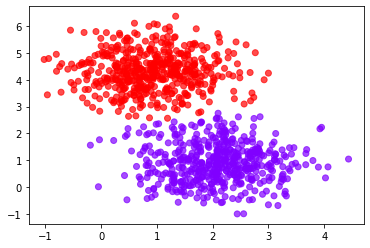

In [5]:
km = KMeans(init='random', n_clusters=2)
km_clustering = km.fit(V)
plt.scatter(V[:,0], V[:,1], c=km_clustering.labels_, cmap='rainbow', alpha=0.7)

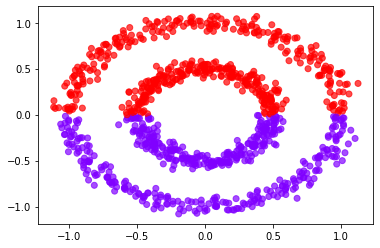

In [6]:
km = KMeans(init='random', n_clusters=2)
km_clustering = km.fit(X)
plt.scatter(X[:,0], X[:,1], c=km_clustering.labels_, cmap='rainbow', alpha=0.7)

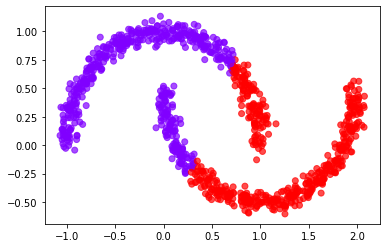

In [7]:
km = KMeans(init='random', n_clusters=2)
km_clustering = km.fit(U)
plt.scatter(U[:,0], U[:,1], c=km_clustering.labels_, cmap='rainbow', alpha=0.7)

**Pros**
- Easy to state, understand, and implement
- Easy to extent to K-median or K-medioid

**Cons**
- Generally only works with spherical data
- Requires us to know number of clusters
- Position of centroid is sensitive to outliers
- Algorithm is sensitive to initial random choice of centroids

**Refined question:** How can we cluster points that are not necessarily spherically shaped?

## III. Networks and Newton's Law of Cooling 
<a id="III-Networks-and-Newton's-Law-of-Cooling"></a>

Say we have $N$ points that are connected in an (undirected) network. We can define these connections with an adjacency matrix $A_{i,j}$. Namely, 

\begin{equation}
A_{i,j} = \begin{cases} 1 & \text{if point $i$ is connected to point $j$} \\[.5em] 0 & \text{otherwise} \end{cases}
\end{equation}

For example on the left we have a network that infers the adjacency matrix on the right

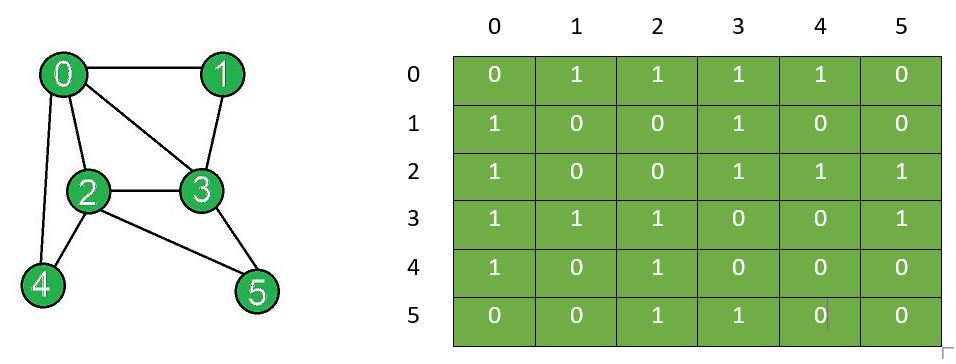

These points could represent the rooms in a hotel or lakes in a river system. 

Let's consider the following question: 

> We have points connected in a network. How can we use the adjacency matrix to determine how heat flows throughout the network contigent on how nodes are connected?

Say that $\phi_i(t)$ for a point $i$ in the network represents the amount of heat at point $i$ at time $t$. By Newton's law of cooling we know that heat flows from high-heat locations to low-heat locations, provided those locations are connected. In particular, if points 1 and 2 are connected, the amount of heat that flows from point 1 to point 2 in a time going from $t$ to $t+\Delta t$

$$ \text{Heat flow from 1 to 2 in time $\Delta t$} = r\,A_{2, 1}\,\Big(\phi_{1}(t) - \phi_2(t)\Big)\Delta t,$$

$r$ is a proportionality constant for the cooling law. $A_{2, 1}$ is to ensure that 1 and 2 are connected. $\Delta t$ accounts for the fact that more heat flows for longer time durations. We can generalize this result to determine the amount of heat that flows to a general point $i$ *from all other points* in a time $\Delta t$

$$  \text{Total heat flow into $i$ in time $\Delta t$} = r\sum_{j=1}^N A_{i, j} \,\Big(\phi_{j}(t) - \phi_i(t)\Big)\Delta t$$

We can convert this into the language of calculus by noting that 

$$\text{Total heat flow into $i$ in time $\Delta t$} = \phi_{i}(t+\Delta t) - \phi_{i}(t)$$

Therefore, 

$$ \phi_{i}(t+\Delta t) - \phi_{i}(t) = r\sum_{j=1}^N A_{i, j} \,\Big(\phi_{j}(t) - \phi_i(t)\Big)$$

which implies for $\Delta t \to 0$

$$ \boxed{\quad\frac{d}{dt} \phi_i = - r \sum_{j=1}^N A_{i, j} \,(\phi_{i} - \phi_j) \qquad \text{[Differential Equation for Law of Cooling]}\quad}$$

From here we will do some reductions. The degree of a node is the number of connections it has to other nodes in the network. So the degree of node $i$ in a network defined by adjacency matrix $A_{i, j}$  is

$$\deg(A)_{i} \equiv \sum_{j=1}^{N} A_{i,j}.$$

We will also use the definition of the "Kronecker delta" $\delta_{i, j}$ as 

\begin{equation}
\delta_{i,j} = \begin{cases} 1 & \text{if $i=j$} \\[.5em] 0 & \text{if $i\neq j$} \end{cases}.
\end{equation}

This quantity has the simple property

$$ \sum_{j=1}^N f_j \delta_{i, j} = f_i$$

Returning to our differential equation for law of cooling, we have
\begin{align}
\frac{d}{dt} \phi_i & = - r\sum_{j=1}^N A_{i,j} (\phi_i - \phi_j)\\[0.5em]
& = - r\left(\phi_i\sum_{j=1}^N A_{i,j} + \sum_{j=1}^N A_{i,j}\phi_j\right)\\[0.5em]
& = - r \left( \phi_i \deg(A)_i  - \sum_{j=1}^{N} A_{ij} \phi_j\right) \\[0.5em]
& = - r \left(\sum_{j=1}^N\deg(A)_{j} \delta_{i,j} \phi_{j} -  \sum_{j=1}^{N} A_{i,j} \phi_j\right)\\[0.5em]
 & = - r \sum_{j=1}^N \left(\deg(A)_{j} \delta_{i j} - A_{i,j} \right) \phi_j,
\end{align}
If we define a matrix $L$ with elements $L_{i, j}$ as 

$$\boxed{\quad L_{i, j} = \deg(A)_{j} \delta_{i j} - A_{i,j} \qquad \text{[Preliminary Definition of Laplacian]} \quad}$$

Namely $L = D- A$ where $D$ is the diagonal matrix whose elements are the degrees of each row, then the final line gives us 

\begin{equation}
\frac{d}{dt} \phi_i = - r \sum_{j=1}^N L_{i j} \phi_{j}. 
\end{equation}

Or if we write this in matrix notation with $\boldsymbol{\phi} = \boldsymbol{\phi} \equiv (\phi_1, \cdots,\phi_N)$, we find 

$$\boxed{\frac{d}{dt} \boldsymbol{\phi} = - r L \boldsymbol{\phi}\qquad \text{[Differential Equation for Law of Cooling]}\quad}$$

This is a linear differential equation for vectors, and as such it has a simple solution. If we were dealing with just scalar functions (i.e., not vectors), we would have a linear differential equation like

$$ \frac{d}{dt} f(t) = - r f(t)  \quad \text{ which has the solution } \quad f(t) = f(0) e^{-rt}$$


For a linear differential equation \textit{for vectors} we write the solution in terms of the eigenvalues and eigenvectors of $L$. We take $\{ \textbf{v}^{(i)}\}$ to be the set of orthonormal eigenvectors of the operator $L$ and $\{\lambda_i\}$ (with $\lambda_1 \leq \lambda_2 \leq \cdots \leq \lambda_N$) to be the corresponding eigenvalues:

$$ L \textbf{v}_{i} = \lambda_i \textbf{v}_{i} $$

If we exapnd the general vector $\boldsymbol{\phi}$ as a linear combination of the eigenvectors of $L$, we have
\begin{equation}
\boldsymbol{\phi}(t) = \sum_{j=1}^{N} c_{j}(t) \textbf{v}^{(j)},
\end{equation}
where $c_j(t)$ are time dependent coefficients. By the properties of $L$ and the differential equation for the law of cooling we have 

$$\frac{d}{dt} c_j(t) = - r\lambda_j c_j(t) \quad \text{ which has the solution } \quad c_j(t) = c_j(0) e^{-r \lambda_j t}.$$

Therefore the general solution to our original Newton's Law of Cooling differential equation 

$$\frac{d}{dt} \phi_i = - r \sum_{j=1}^N A_{i, j} \,(\phi_{i} - \phi_j)$$

is 
\begin{equation}
\boxed{\quad \boldsymbol{\phi}(t) =  \sum_{j=1}^{N} c_{j}(0) e^{- r\lambda_j t}\, \textbf{v}^{(j)}\quad},
\end{equation}

**Important Notes**
1. The adjacency matrix $A$ defines how nodes in the network are connected, but when trying to determine how "stuff" flows through the nodes of the network, the Laplacian $L = D-A$ (in particular its eigenvalues and eigenvectors) emerge as the most important theoretical quantities 


2. Smallest eigenvalues (i.e, $\lambda_j \ll 1$) correspond to eigenvectors with the most "long-lasting" time behavior. This means eigenvectors with small eigenvalues are more important in representing the connectivity properties of the network


We recall our starting question

> We have points connected in a network. How can we use the adjacency matrix to determine how "stuff" flows throughout the network contigent on how nodes are connected?

**Main Takeaway**
If we have a network defined by an adjaceny matrix, we can compute the Laplacian and then the eigenvectors and eigenvalues of the Laplacian in order to have a representation of how "stuff" flows through the connected components of the network.

## IV. Definition of the Laplacian
<a id="IV-Definition-of-the-Laplacian"></a>

If we have an adjacency matrix $A$, we can compute a degree matrix $D$ (the diagnonal matrix of the degree of each node) and then the Laplacian $L = D-A$. Here's an example

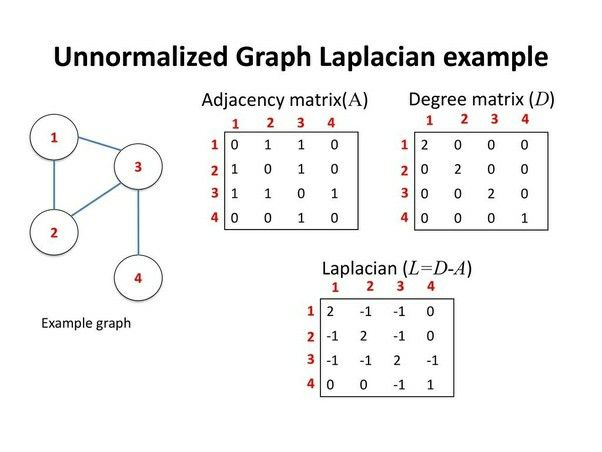

But because $D$ is a diagonal matrix, we can also define other forms of the Laplacian with the same eigenvector/eigenvalue properies. 

## V. Principal Component Analysis
<a id="V-Principal-Component-Analysis"></a>

In principal component analysis, we find the components that best encompass the variability in the data. Let our set of $N$ data points be defined by a set of vectors $\{\textbf{X}_i\}$ where $i$ runs from $1$ to $N$ and the dimensions of $\textbf{X}_i$ are $M$ (i.e., each $\textbf{X}$ has $M$ components). Then we can define a covariance matrix $C$ with components $C_{i, j}$ as 

\begin{equation}
C_{i, j} = \frac{1}{N} (\textbf{X}_{i} - \overline{X})\cdot (\textbf{X}_{j} - \overline{X}),
\end{equation}

where $\overline{X} = \frac{1}{N} \sum_{i=1}^N \textbf{X}_i$. 

The "principal components" of the data set defined by $\{\textbf{X}_i\}$ are **the eigenvectors of the matrix $C$ which have the largest eigenvalues**. Such eigenvectors encompass the most variability in the data and can thus serve as a representation for the data

How is this related to networks and Laplacians?

We found above that if we think of networks as defining the flow of stuff (e.g., heat), then the eigenvectors and eigenvalues of the Laplacian are essential in determining exactly how such stuff flows from one node to the next. In particular the eigenvectors with the lowest values are the most important.

**Main Takeaway**
- In the same way we can characterize dataset *variability* with the eigenvectors of the covariance matrix, we can characterize dataset *connectivity* with the eigenvectors of the Laplacian. 

How should we...

$$ \text{...represent vectors to optimize for} \textit{ data variability?} \quad \longrightarrow \quad \text{Compute eigenvectors of Covariance Matrix (i.e., PCA)}$$

and

$$ \text{...represent vectors to optimize for } \textit{data connectivity?} \quad \longrightarrow \quad \text{Compute eigenvectors of Laplacian Matrix}$$

Perhaps using the eigenvectors of the laplacian of a data set, we can find a data representation that is better for clustering.

## VI. Adjacency Matrix From Points
<a id="VI-Adjacency-Matrix-From-Points"></a>

There is one missing piece: 

> How do we go from a set of vectors $\{\textbf{X}_i\}$ to an adjacency matrix $A$ that we can use to compute the Laplacian?

An adjacency matrix defines how points are connected. One simple way to define an adjacency matrix given a set of points in a dimensional space is to compute the distance between the points, and then normalize the distance in some way. 

Computing distance

$$ \text{Distance}_{i, j} = ||\text{X}_i - \text{X}_{j}||$$

Defining an adjacency matrix based on this distance

$$ \text{Adjacency Matrix}_{i, j} = \exp\left( - \text{Distance}_{i, j}\right) =  \exp \left( - ||\text{X}_i - \text{X}_{j}|| \right)$$

Points that are very far away have $A_{i, j} \simeq 0$. Points that are close together have $A_{i, j} \simeq 1$.

*Note that this adjacency matrix is a weighted adjacency matrix, where values need not be 1 or 0*.

## VII. Spectral Clustering Algorithm
<a id="VII-Spectral-Clustering-Algorithm"></a>

All of this prior development leads us to a new algorithm for clustering. 

We have a data set $\{\textbf{X}_i\}$ that we want to separate into $C$ clusters. The essential idea behind Spectral clustering is

1. Compute the adjacency matrix $A_{i, j} =  \exp \left( - ||\text{X}_i - \text{X}_{j}|| \right)$ for the data set
2. Compute the Laplacian $L= D-A$ from the adjacency matrix where $D$ is the "degree" matrix
3. Compute the eigenvectors of the Laplacian
4. Perform $k$-means clustering on these Laplacian eigenvectors

(A bit more complicated than this but this is the essential idea)

## VIII. Return to Original Question
<a id="VIII-Return-to-Original-Question"></a>

> How can we find clusters for our plots of points? 

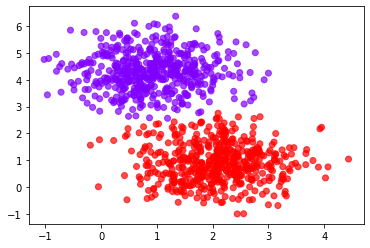

In [8]:
sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=0)
sc_clustering = sc.fit(V)
plt.scatter(V[:,0], V[:,1], c=sc_clustering.labels_, cmap='rainbow', alpha=0.7)

[2022-02-01 10:12:18,150] [ WARNING] :: /Users/mobolajiwilliams/.local/share/virtualenvs/jellyfish-u6-MYayp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 (py.warnings|warnings.py:109)


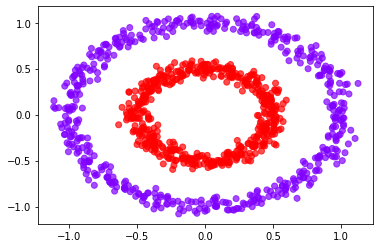

In [9]:
sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=0)
sc_clustering = sc.fit(X)
plt.scatter(X[:,0], X[:,1], c=sc_clustering.labels_, cmap='rainbow', alpha=0.7)

[2022-02-01 14:00:19,180] [ WARNING] :: /Users/mobolajiwilliams/.local/share/virtualenvs/jellyfish-u6-MYayp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 (py.warnings|warnings.py:109)


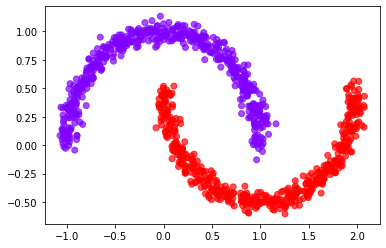

In [66]:
sc = SpectralClustering(n_clusters=2, n_components = 2, affinity='nearest_neighbors', random_state=0)
sc_clustering = sc.fit(U)
plt.scatter(U[:,0], U[:,1], c=sc_clustering.labels_, cmap='rainbow', alpha=0.7)

## Supplementary Question

> In the standard spectral clustering algorithm, we take the $k$ lowest-eigenvalue eigenvectors of the $N\times N$ Laplacian as our feature representation for our $N$ point data set, and then apply $k$-means clustering to this feature representation. Would the algorithm still work if we use all $N$ eigenvectors? What's the advantage to using only the lowest $k$?

Using a larger value of $k$ introduces more noise into the clustering and makes it more difficult for $k$-means to find adequate clusters. For example, below we depict the same clustering as we did above except we explicitly state we are considering 10 rather than 2 eigenvectors

[2022-02-01 18:49:40,130] [ WARNING] :: /Users/mobolajiwilliams/.local/share/virtualenvs/jellyfish-u6-MYayp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 (py.warnings|warnings.py:109)


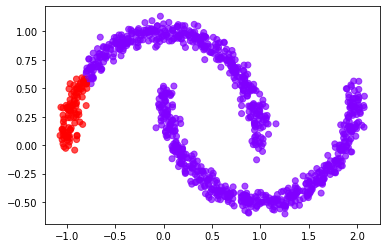

In [146]:
sc = SpectralClustering(n_clusters=2, n_components = 10, affinity='nearest_neighbors', random_state=0)
sc_clustering = sc.fit(U)
plt.scatter(U[:,0], U[:,1], c=sc_clustering.labels_, cmap='rainbow', alpha=0.7)

We see that the clustering does not perform well.

Using the full (or close to full) dimensional space of 1000 eigenvectors gives us even worse results:

[2022-02-01 14:03:12,818] [ WARNING] :: /Users/mobolajiwilliams/.local/share/virtualenvs/jellyfish-u6-MYayp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 (py.warnings|warnings.py:109)


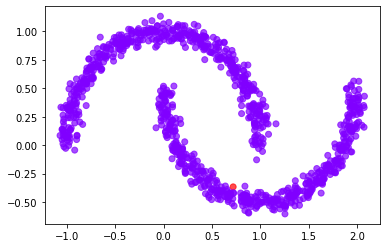

In [70]:
sc = SpectralClustering(n_clusters=2, n_components = U.shape[0]-1, affinity='nearest_neighbors', random_state=0)
sc_clustering = sc.fit(U)
plt.scatter(U[:,0], U[:,1], c=sc_clustering.labels_, cmap='rainbow', alpha=0.7)

We see hardly any clustering at all. Essentially the problem is that with a feature space with the same number of dimensions as we have data elements (1000 in this case), the distance between points is no longer a good metric for determining proximity (See https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions for more details). 

So we need to reduce the dimensional space in order for distance (and algorithms based on distance such as $k$-means) to become useful. 

Therefore we want to use the minimum number of eigenvectors needed to depict the clustering properties of the data. For laplacians, if there are $k$ eigenvalues with a value of $0$ then, the associated network has $k$ connected components and these connected components can be characterized by the associated eigenvectors. Reasoning conversely, if we wanted to know the eigenvectors that could best characterize $k$ connected components in a graph, we would select the first $k$ eigenvectors closest to $0$. This leads us to only selecting the lowest (by eigenvalue) $k$ eigenvectors to represent our feature space:

[2022-02-01 18:53:26,199] [ WARNING] :: /Users/mobolajiwilliams/.local/share/virtualenvs/jellyfish-u6-MYayp/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 (py.warnings|warnings.py:109)


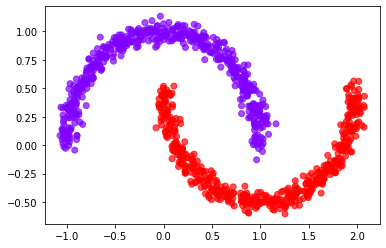

In [147]:
sc = SpectralClustering(n_clusters=2, n_components = 2, affinity='nearest_neighbors', random_state=0)
sc_clustering = sc.fit(U)
plt.scatter(U[:,0], U[:,1], c=sc_clustering.labels_, cmap='rainbow', alpha=0.7)

---------------

### Appendix: Spectral Clustering From Scracth

To affirm the above addendum we will implement the spectral clustering algorithm from scratch. Specifically we implement the algorithm from scratch up to the application of $k$-means. 

We find that rather than the adjacency matrix provided in the above development, one based on nearest neighbors provides leads to better clustering properties 

We will define our adjacency matrix as 

$$ \text{Adjacency Matrix}_{i, j} = \begin{cases} 1 & \text{if $j$ is one of the $n$ closest neighbors of $i$} \\ 0 & \text{otherwise} \end{cases} $$

This is the adjacency matrix definition used in python for its Spectral clustering algorithm, although it's not the one often referenced in the primary literature (e.g., by Ng, Jordan, Weisss). 

We choose $n=5$ for the subsequent sections. 


In [25]:
# computing distance matrix
from scipy.spatial import distance_matrix
from heapq import nsmallest
import numpy as np

In [148]:
## computing distance matrix
dist_matrix = distance_matrix(X, X)

## [NOT USED] gaussian kernal adjacency matrix
## adjacency_matrix = np.exp(-dist_matrix/0.25) # choose .5 scaling arbitrarily

## nearest neighbors adjacency matrix
adjacency_matrix = np.zeros((X.shape[0], X.shape[0]))
n_neighbors = 5
for k in range(X.shape[0]):
    smallest_pairs = nsmallest(n_neighbors+1, zip(dist_matrix[k], range(X.shape[0])))
    smallest_indx = [elem[1] for elem in smallest_pairs]    
    for elem in smallest_indx:
        adjacency_matrix[k, elem]=1
            
## makind adjacency matrix symmetric
adjacency_matrix = (adjacency_matrix + adjacency_matrix.T)/2

## computing laplacian matrix
degree_matrix = np.sum(adjacency_matrix, axis = 0)*np.identity(X.shape[0])
laplacian_matrix =degree_matrix - adjacency_matrix

## [NOT USED] normalized lapacian matrix
## inverse_sqrt_degree = np.sqrt(np.linalg.inv(degree_matrix))
## laplacian_matrix = np.matmul(np.matmul(inverse_sqrt_degree,adjacency_matrix),inverse_sqrt_degree)

In [170]:
## computing eigenvalues 
e_values = np.linalg.eig(laplacian_matrix)[0].tolist()
e_vectors = np.linalg.eig(laplacian_matrix)[1]

In [171]:
## [NOT USED] checking evalue; chosen adjacency matrix has led
## to there being many zero values for eigenvalues and thus the 
## standard eigenvector check is unstable
np.dot(laplacian_matrix, e_vectors[:,1])/e_vectors[:,1]/e_values[1];

In [155]:
## computing feature matrix
n_components = 2
optimal_evalues = nsmallest(n_components, e_values)
feature_mat = list()
for val in optimal_evalues:
    indx = e_values.index(val)
    feature_mat.append(e_vectors[:,indx].tolist())
feature_mat = np.array(feature_mat).T


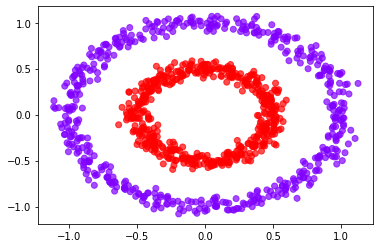

In [156]:
## applying k means
km = KMeans(n_clusters=2, random_state=42)
km_clustering = km.fit(feature_mat)
plt.scatter(X[:,0], X[:,1], c=km_clustering.labels_, cmap='rainbow', alpha=0.7)

In [175]:
## eigenvalue and eigenvector check
a = np.array([[3, 1], [2, 2]])
w, v = np.linalg.eig(a) # evalues, evectors

# should be a vector of 1s 
np.dot(a, v[:,0])/v[:,0]/w[0]

array([1., 1.])